# Libs and data loading

In [1]:


import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")

import os
import warnings
from pprint import pprint

warnings.simplefilter('ignore')

import plotly.express as px
import plotly.figure_factory as ff

import spacy
from spacy import displacy

import scispacy
import medspacy

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


import stylecloud
from IPython.display import Image
from collections import Counter, defaultdict
import ast

%load_ext memory_profiler

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dreamtim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
features = pd.read_csv("data/features.csv")
patient_notes = pd.read_csv("data/patient_notes.csv")
submission = pd.read_csv("data/sample_submission.csv")

# Understand the data

Read the data:

The history of patients written by students who took the USMLE exam is in `patient_notes.csv`:

In [3]:
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


Let us view a sample patient note for patient_number 16 and case number 0:

In [4]:
print(patient_notes[patient_notes['pn_num']==16][patient_notes['case_num']==0]['pn_history'].values[0])

HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms


To evaluate the history written we have `features.csv` which have 3 columns:


In [5]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


- **feature_num** is a unique identifier for each feature
- **case_num** is an identifier for case number
- **feature_text** contains the sentences which should be ideally present in the patient_notes written by test taker.

Here is the right answer for the note with patient_number 16 and case number 0, which we just took a look at:

In [6]:
for x in features[features['case_num']==0]['feature_text']:
    print (x)

Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male


Here we easily see that on 4th last line its written "FHx: mom with "thyroid disease," dad with recent heart attcak" which is similar to "Family-history-of-thyroid-disorder" and "Family-history-of-MI-OR-Family-history-of-myocardial-infarction" written on the feature_text.

But how to **label** it?

We can also say that in Patient note of patient no: 16; from character 668 to 693 is similar to "Family-history-of-thyroid-disorder" and from character 696 to 724 is similar to "Family-history-of-MI-OR-Family-history-of-myocardial-infarction".

The same part is done by kaggle, they have stated the location for the similar sentence to a feature present in the patient note, see `train.csv`:

In [7]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


Let us again check how our note with patient_number 16 and case number 0 looks like:

In [8]:
train[train['pn_num']==16][train['case_num']==0]

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
5,00016_005,0,16,5,[],[]
6,00016_006,0,16,6,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']"
7,00016_007,0,16,7,[],[]
8,00016_008,0,16,8,[],[]
9,00016_009,0,16,9,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']"


# EDA

### Train data

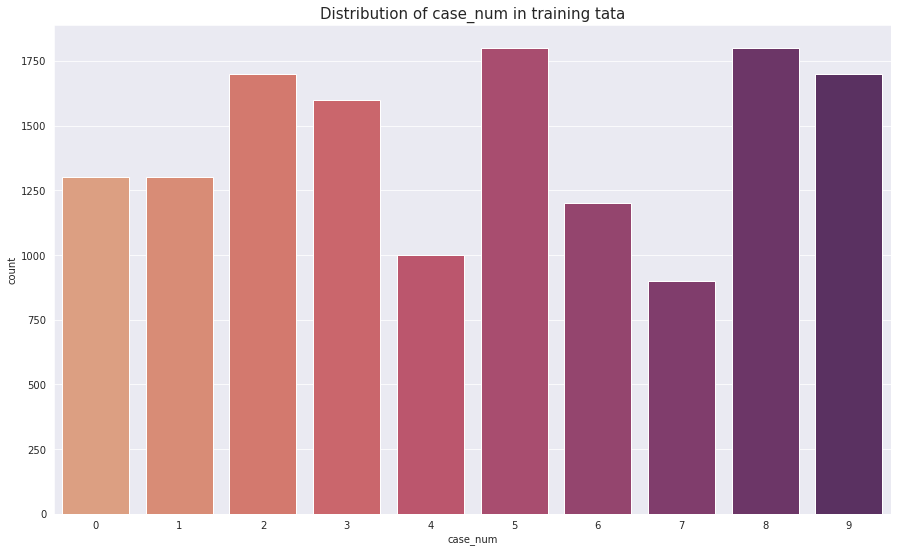

In [9]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=train, palette = 'flare')
plt.title('Distribution of case_num in training tata', fontsize=15)

plt.show()

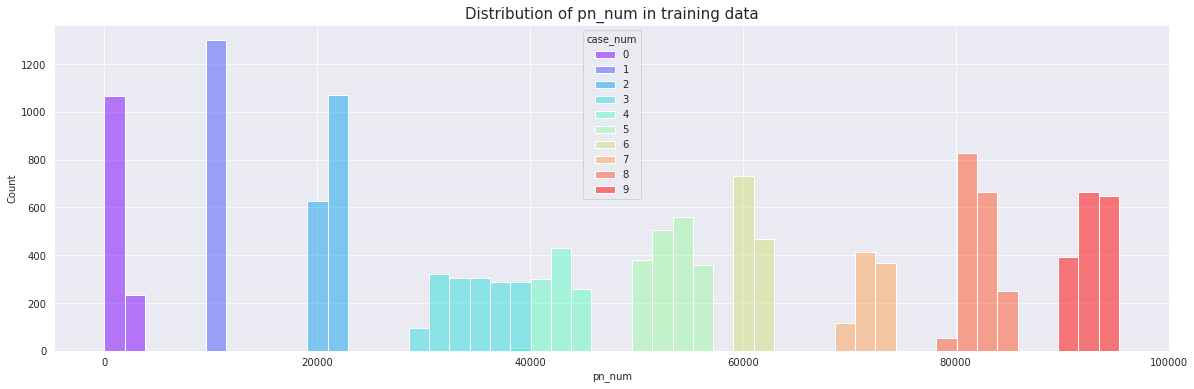

In [10]:
plt.figure(figsize=(20, 6))

sns.histplot(x='pn_num', data=train, hue='case_num', bins=50, palette='rainbow')
plt.title('Distribution of pn_num in training data', fontsize=15)

plt.show()

Number of features in the annotations and most common words in the annotations:

Number of Rows with no Annotations - 4399
Number of Rows with Annotations - 9901


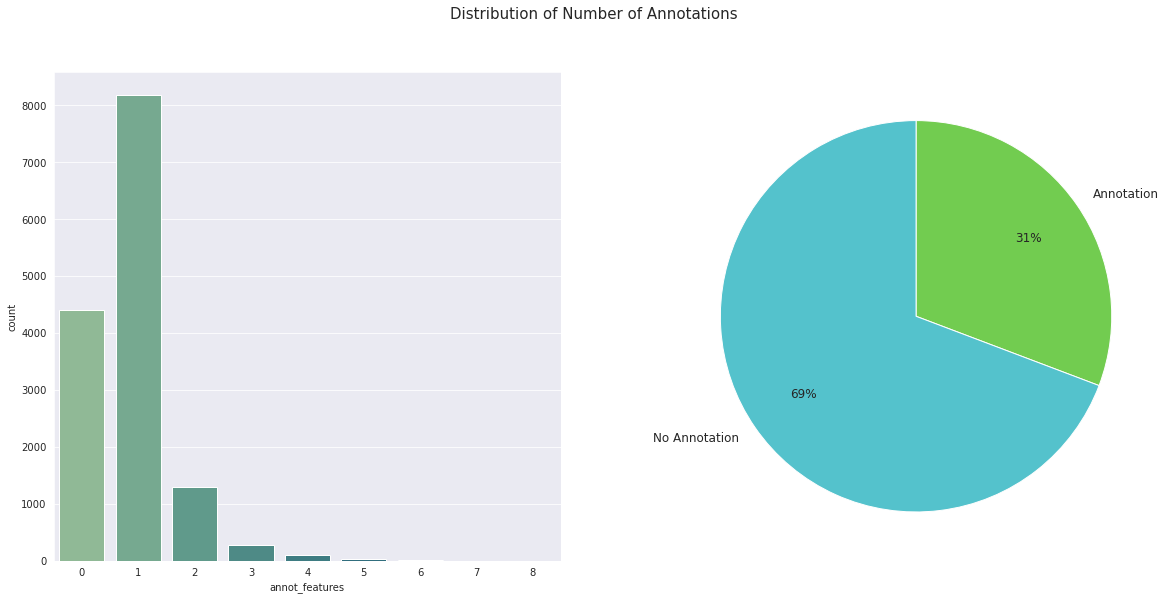

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Distribution of Number of Annotations', size=15)
# Here we just eval the strings in annotation columns
# to get the number of elements in these lists
train['annot_features'] = train['annotation'].apply(lambda x : len(ast.literal_eval(x))) 
sns.countplot(x=train['annot_features'], palette='crest', ax=ax[0])

sizes = []
no_annotations = len(train[train['annot_features']==0])
sizes.append(no_annotations)
annotated = len(train) - len(train[train['annot_features']==0])
sizes.append(annotated)

print('Number of Rows with no Annotations -', no_annotations)
print('Number of Rows with Annotations -', annotated)

labels = ['Annotation', 'No Annotation']
colors = ['#72CC50', '#54C2CC']
ax[1].pie(sizes, colors=colors, startangle=90, labels=labels,
        autopct='%1.0f%%', pctdistance=0.7,textprops={'fontsize':12}, counterclock=False)

plt.show()

It would be cool to **annotate more data** somehow!

In [12]:
def join_fea(annotation):
    text = [word for words in ast.literal_eval(annotation) for word in words.split()]
    return text

train['text'] = train['annotation'].apply(lambda x : join_fea(x))

top = Counter([word for words in train['text'] for word in words])
df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words(including stopwords) in Annotations', orientation='h', width=900,height=700, color='Common_words')
fig.show()

def join_fea(annotation):
    text = [word for words in ast.literal_eval(annotation) for word in words.split() if word not in set(stopwords.words('english'))]
    return text

train['text'] = train['annotation'].apply(lambda x : join_fea(x))

top = Counter([word for words in train['text'] for word in words])
df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words(excluding stopwords) in Annotations', orientation='h', width=900,height=700, color='Common_words')
fig.show()

### Features data

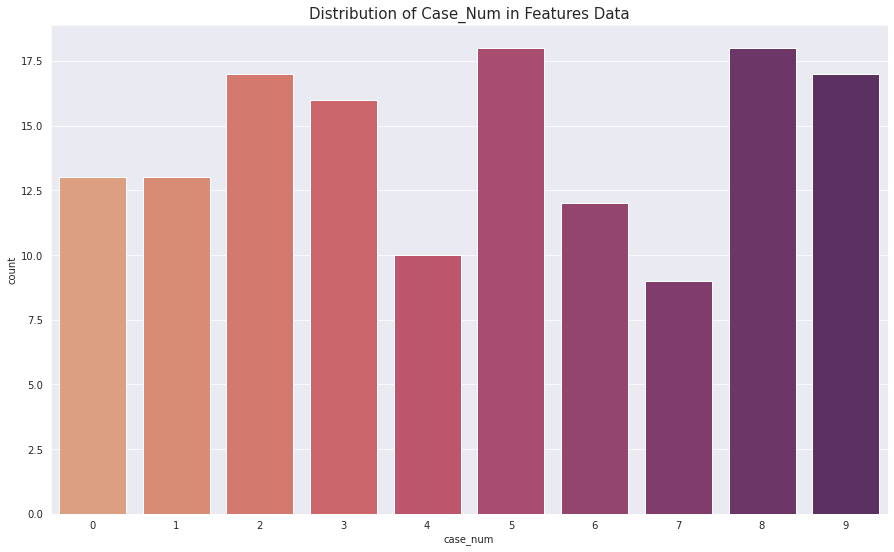

In [13]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=features,  palette = 'flare')
plt.title('Distribution of Case_Num in Features Data', fontsize=15)

plt.show()

### Patient Notes Data

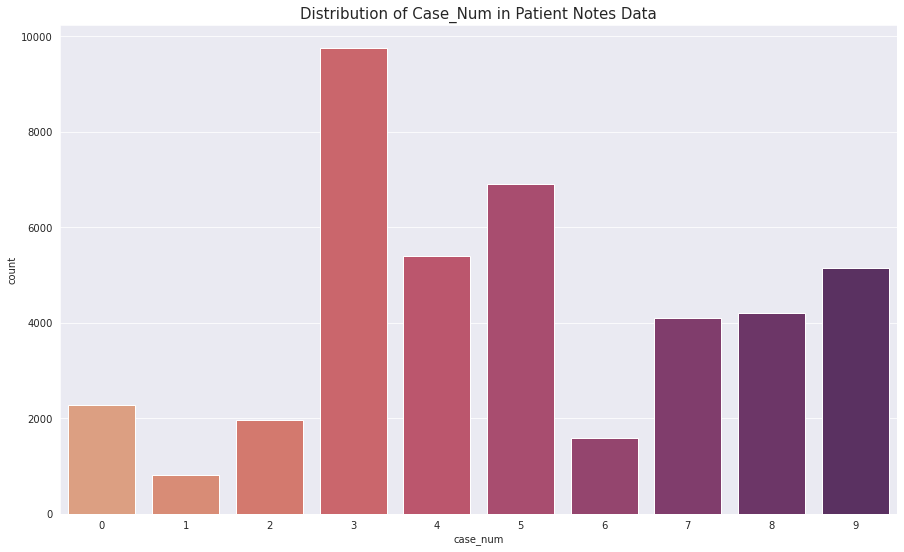

In [14]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=patient_notes, palette = 'flare')
plt.title('Distribution of Case_Num in Patient Notes Data', fontsize=15)

plt.show()

# Basic preprocessing

### Annotate with exact match to get more training  data

In [15]:
pn_dict = {}
for idx, row in patient_notes.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']
    
    
new_annotation = []
for case_id in features['case_num'].unique():
    
    all_pn_id = set(patient_notes[patient_notes['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in features[features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(train[train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = train[train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
        break
    break
    # break to get sample results quickly
    
print(f'We got {len(new_annotation)} new annotations!')

We got 876 new annotations!


### Merge all the data

In [16]:
train_annotations = pd.DataFrame(new_annotation, columns=train.columns[:-2])

train_annotations.set_index('id', inplace=True)
train.set_index('id',  inplace=True)

train = train.combine_first(train_annotations)

In [17]:
train.combine_first(train_annotations).loc['2441_000']

annot_features                       NaN
annotation        [father: heart attack]
case_num                             0.0
feature_num                          0.0
location                       [903 923]
pn_num                            2441.0
text                                 NaN
Name: 2441_000, dtype: object

In [18]:
train.reset_index(inplace=True)

df = train.merge(features, how='left')
df = df.merge(patient_notes, on=['pn_num', 'case_num'], how='left')

df = df.set_index('id')

df.head()

,annot_features,annotation,case_num,feature_num,location,pn_num,text,feature_text,pn_history
id,,,,,,,,,
0000_000,NaN,[father had MI],0.0,0.0,[553 566],0.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,"17-year-old male, has come to the student heal..."
00016_000,1.0,['dad with recent heart attcak'],0.0,0.0,['696 724'],16.0,"[dad, recent, heart, attcak]",Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
00016_001,1.0,"['mom with ""thyroid disease']",0.0,1.0,['668 693'],16.0,"[mom, ""thyroid, disease]",Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
00016_002,1.0,['chest pressure'],0.0,2.0,['203 217'],16.0,"[chest, pressure]",Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
00016_003,2.0,"['intermittent episodes', 'episode']",0.0,3.0,"['70 91', '176 183']",16.0,"[intermittent, episodes, episode]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...


In [19]:
features.case_num = features.case_num.astype('int64')
features.feature_num = features.feature_num.astype('int64')

features.case_num = features.case_num.astype('int64')
features.feature_num = features.feature_num.astype('int64')

In [20]:
patient_notes = patient_notes.set_index(['case_num', 'pn_num'])
features = features.set_index(['case_num', 'feature_num'])

In [21]:
patient_notes

pn_history
case_num pn_num                                                   
0        0       17-year-old male, has come to the student heal...
         1       17 yo male with recurrent palpitations for the...
         2       Dillon Cleveland is a 17 y.o. male patient wit...
         3       a 17 yo m c/o palpitation started 3 mos ago; \...
         4       17yo male with no pmh here for evaluation of p...
...                                                            ...
9        95330   Ms. Madden is a 20 yo female presenting w/ the...
         95331   A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
         95332   Ms. Madden is a 20yo female who presents with ...
         95333   Stephanie madden is a 20 year old woman compla...
         95334   patient is a 20 yo F who presents with a heada...

[42146 rows x 1 columns]

In [22]:
features

feature_text
case_num feature_num                                                   
0        0            Family-history-of-MI-OR-Family-history-of-myoc...
         1                           Family-history-of-thyroid-disorder
         2                                               Chest-pressure
         3                                        Intermittent-symptoms
         4                                                  Lightheaded
         5            No-hair-changes-OR-no-nail-changes-OR-no-tempe...
         6                                                 Adderall-use
         7                                          Shortness-of-breath
         8                                                 Caffeine-use
         9                               heart-pounding-OR-heart-racing
         10                                         Few-months-duration
         11                                                     17-year
         12                                                        Male
1        100                                       No-vaginal-discharge
         101                                                Weight-loss
         102                                        Not-sexually-active
         103                                 Prior-episodes-of-diarrhea
         104                                                    20-year
         105                                  No-bloody-bowel-movements
         106                         Recurrent-bouts-over-past-6-months
         107          Right-sided-LQ-abdominal-pain-OR-Right-lower-q...
         108                                        No-urinary-symptoms
         109                                        Diminished-appetite
         110          Normal-LMP-2-weeks-ago-OR-Normal-last-menstrua...
         111                                8-to-10-hours-of-acute-pain
         112                                                     Female
2        200                                       Prior-normal-periods
         201                                  Last-Pap-smear-I-year-ago
         202                                                        IUD
         203                                            Sexually-active
         204                                            Vaginal-dryness
         205                                           Irregular-menses
         206          Recent-nausea-vomiting-OR-Recent-flulike-symptoms
         207                                   No-premenstrual-symptoms
         208                                                     Female
         209                                                     Stress
         210          LMP-2-months-ago-or-Last-menstrual-period-2-mo...
         211                                                Hot-flashes
         212          Irregular-flow-OR-Irregular-frequency-OR-Irreg...
         213                                          Onset-3-years-ago
         214                                             Heavy-sweating
         215                      Sleep-disturbance-OR-Early-awakenings
         216                                                    44-year
3        300          FHx-of-PUD-OR-Family-history-of-peptic-ulcer-d...
         301                                      Epigastric-discomfort
         302                                     Darker-bowel-movements
         303          NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...
         304                  burning-OR-gnawing-OR-burning-and-gnawing
         305              Post-prandial-bloating-OR-fullness-with-meals
         306          getting-worse-OR-progressive-OR-symptoms-now-d...
         307                                        2-to-3-beers-a-week
         308                                                       Male
         309                                          duration-2-months
         310                                           Awakens-at-night
         311               

In [23]:
df = df.sort_values(by=['case_num', 'pn_num', 'feature_num'])
df.head()

,annot_features,annotation,case_num,feature_num,location,pn_num,text,feature_text,pn_history
id,,,,,,,,,
0000_000,NaN,[father had MI],0.0,0.0,[553 566],0.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,"17-year-old male, has come to the student heal..."
0005_000,NaN,[father - MI],0.0,0.0,[825 836],5.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,"17 yo m, presenting with palpitations/increase..."
0007_000,NaN,[Father MI],0.0,0.0,[490 499],7.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,17 yo male presents with a 2-3 month history o...
0009_000,NaN,[father had MI],0.0,0.0,[709 722],9.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,Mr. Cleveland is a 17 yo M who presents to cli...
0011_000,NaN,[Father had MI],0.0,0.0,[684 697],11.0,NaN,Family-history-of-MI-OR-Family-history-of-myoc...,Dillon Cleveland is a 17 year old male with no...


### SpaCy

Now we will convert string data into SpaCy Docs. Previously we used nltk to remove stopwords, but we can actually do all this stuff in SpaCy.

##### Initialize SpaCy and process the texts

In [24]:
fast_nlp = spacy.load('en_core_web_sm')

In [25]:
spacy_patient_notes = pd.DataFrame(index=patient_notes.index)

notes_num = len(patient_notes)
done_num = 0

def to_fast_doc(text_field):
    global done_num
    print(f'{done_num/notes_num*100: .2f} %', end='\r')
    done_num += 1
    return fast_nlp(text_field)

print(f'We are going to process {notes_num} notes...')

We are going to process 42146 notes...


In [26]:
spacy_patient_notes['fast_doc'] = patient_notes.pn_history.apply(to_fast_doc)

##### Extract some batches from the processed texts

In [27]:
%%timeit

# CELL IS NOT IN USE
# This way takes more time and less concise

to_batches = spacy_patient_notes.reset_index()

batch_0 = to_batches[(to_batches.case_num == 0) &
                     (to_batches.pn_num < 20) &
                     (to_batches.pn_num >= 16)]

batch_1 = to_batches[(to_batches.case_num == 1) &
                     (to_batches.pn_num < 10990) &
                     (to_batches.pn_num >= 10986)]

6.56 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit

batch_0 = spacy_patient_notes.query('(case_num == 0) and (16 <= pn_num < 20)')
batch_1 = spacy_patient_notes.query('(case_num == 0) and (10986 <= pn_num < 10990)')

5.04 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
batch_0 = spacy_patient_notes.query('(case_num == 0) and (16 <= pn_num < 20)')

In [32]:
print('Batch from case 0:\n')

for fast_doc in batch_0.fast_doc:
    displacy.render(fast_doc, style='ent')
    print('-----')
    
print('Batch from case 1:\n')

for fast_doc in batch_1.fast_doc:
    displacy.render(fast_doc, style='ent')
    print('-----')

Batch from case 0:



-----


-----


-----


-----
Batch from case 1:



##### SciSpacy

In [ ]:
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_scibert-0.5.0.tar.gz

In [ ]:
sci_nlp = spacy.load('en_core_sci_scibert')

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
add_code_sample_docstrings() got an unexpected keyword argument 'tokenizer_class'

In [ ]:
print('Try trf for batch from case 0:\n')

for text in (fast_doc.text for fast_doc in batch_0.fast_doc):
    doc = sci_nlp(text)
    displacy.render(doc, style='ent')
    print('-----')

print('Try trf for batch from case 1:\n')
    
for text in (fast_doc.text for fast_doc in batch_0.fast_doc):
    doc = sci_nlp(text)
    displacy.render(doc, style='ent')
    print('-----')

##### Add custom ents for annotations

In [ ]:
for case_num, pn_num in zip(batch_0.case_num, batch_0.pn_num):
    print(case_num, pn_num)

AttributeError: 'DataFrame' object has no attribute 'case_num'

In [ ]:
example_features = df.loc[(df.case_num == 0) & (df.pn_num == 16)]

example_locations = example_features.location.to_dict()
example_locations = {id: ast.literal_eval(s) for id, s in example_locations.items()}

In [ ]:
example_locations

{'00016_000': ['696 724'],
 '00016_001': ['668 693'],
 '00016_002': ['203 217'],
 '00016_003': ['70 91', '176 183'],
 '00016_004': ['222 258'],
 '00016_005': [],
 '00016_006': ['321 329', '404 413', '652 661'],
 '00016_007': [],
 '00016_008': [],
 '00016_009': ['26 38', '96 118'],
 '00016_010': ['56 69'],
 '00016_011': ['5 9'],
 '00016_012': ['10 11']}

In [ ]:
example_features

,annot_features,annotation,case_num,feature_num,location,pn_num,text,feature_text,pn_history
id,,,,,,,,,
00016_000,1.0,['dad with recent heart attcak'],0.0,0.0,['696 724'],16.0,"[dad, recent, heart, attcak]",Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
00016_001,1.0,"['mom with ""thyroid disease']",0.0,1.0,['668 693'],16.0,"[mom, ""thyroid, disease]",Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
00016_002,1.0,['chest pressure'],0.0,2.0,['203 217'],16.0,"[chest, pressure]",Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
00016_003,2.0,"['intermittent episodes', 'episode']",0.0,3.0,"['70 91', '176 183']",16.0,"[intermittent, episodes, episode]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
00016_004,1.0,['felt as if he were going to pass out'],0.0,4.0,['222 258'],16.0,"[felt, going, pass]",Lightheaded,HPI: 17yo M presents with palpitations. Patien...
00016_005,0.0,[],0.0,5.0,[],16.0,[],No-hair-changes-OR-no-nail-changes-OR-no-tempe...,HPI: 17yo M presents with palpitations. Patien...
00016_006,3.0,"['adderall', 'adderrall', 'adderrall']",0.0,6.0,"['321 329', '404 413', '652 661']",16.0,"[adderall, adderrall, adderrall]",Adderall-use,HPI: 17yo M presents with palpitations. Patien...
00016_007,0.0,[],0.0,7.0,[],16.0,[],Shortness-of-breath,HPI: 17yo M presents with palpitations. Patien...
00016_008,0.0,[],0.0,8.0,[],16.0,[],Caffeine-use,HPI: 17yo M presents with palpitations. Patien...


# Understand the task

In [ ]:
train.head()

In [ ]:
test.head()

So, (annotation, location) is target what we should predict well

In [ ]:
submission.head()

We should fill up location value in `submisson.csv`

# Model

### From SpaCy to PyTorch